#   ROGUE Scores Llama2 vs LLama2 Fine-Tuned

In [1]:
# !pip install -r rouge/requirements.txt
!pip install -q -U rouge-score
!pip install -q -U "git+https://github.com/pltrdy/rouge"

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


### Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import os
# import time
# import json


from rouge import Rouge
from rouge_score import rouge_scorer
# from time import perf_counter

### Check ROGUE_Scorer Package

In [3]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False)
scores = scorer.score('The quick brown fox jumps over the lazy dog',
                      'The quick brown dog jumps on the log.')
print(scores)
display(pd.DataFrame(scores))

{'rouge1': Score(precision=0.75, recall=0.6666666666666666, fmeasure=0.7058823529411765), 'rouge2': Score(precision=0.2857142857142857, recall=0.25, fmeasure=0.26666666666666666), 'rougeL': Score(precision=0.625, recall=0.5555555555555556, fmeasure=0.5882352941176471)}


,rouge1,rouge2,rougeL
0,0.750000,0.285714,0.625000
1,0.666667,0.250000,0.555556
2,0.705882,0.266667,0.588235


### Check ROGUE Package

In [4]:
hypothesis = "the #### transcript is a written version of each day 's cnn student news program use this transcript to he    lp students with reading comprehension and vocabulary use the weekly newsquiz to test your knowledge of storie s you     saw on cnn student news"

reference = "this page includes the show transcript use the transcript to help students with reading comprehension and     vocabulary at the bottom of the page , comment for a chance to be mentioned on cnn student news . you must be a teac    her or a student age # # or older to request a mention on the cnn student news roll call . the weekly newsquiz tests     students ' knowledge of even ts in the news"

rouge = Rouge()
scores = rouge.get_scores(hypothesis, reference)
display(pd.DataFrame(scores))

,rouge-1,rouge-2,rouge-l
0,"{'r': 0.42857142857142855, 'p': 0.583333333333...","{'r': 0.18571428571428572, 'p': 0.317073170731...","{'r': 0.3877551020408163, 'p': 0.5277777777777..."


### Global Constants

In [13]:
# GDrive Location for Train/Test Data
DATA_PATH ="/content/drive/MyDrive/Text2SQL/Text2SQL/Data/"
DS_DIR = "sql_train_test"
PKL_DIR = "test/"
PKL_FILE ="sql_test.pkl"
LLAMA_PKL_FILE="sql_test_Llama2.pkl"
LLMRES_PKL_FILE="sql_test_llmresfinal.pkl"

# Results
RES_PATH="/content/drive/MyDrive/Text2SQL/Text2SQL/Results/"
LLAMA_RES_FILE="llama_rogue.csv"
FINETUNE_RES_FILE="finetune_rogue.csv"

# Fig Constants
FIG_PATH="/content/drive/MyDrive/Text2SQL/Text2SQL/Figs/"
FIG_NAME="ROGUE_Scores_Llama_vs_Finetune.png"

### Common Functions

In [6]:
def compute_rogue(df):
  '''Computes Avg ROGUE Scores: ROGUE-1,2,L and returns results as Dataframe'''
  rouge = Rouge()

  # Convert to List
  df_res = df['eval_res'].tolist()
  df_ref = df['response'].tolist()

  # Get Rogue-1, Rogue-2, Rogue-L as dict
  rogue_dict = rouge.get_scores(df_res, df_ref, avg=True)

  # Convert Dict to DataFrame
  rogue_df = pd.DataFrame(rogue_dict)

  return rogue_df

In [7]:
def create_plt_df(df, index_names=['metric', 'type'], column_names=['llama2']):
  plt_df = pd.DataFrame(df.unstack(), columns=column_names)
  plt_df.reset_index(names=index_names, inplace=True)
  plt_df[index_names[1]] = plt_df[index_names[1]].map({'r': 'Recall', 'p':'Precision', 'f':'F1-Score'})
  return plt_df

### Read in Evaluation Files

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
llama_df=pd.read_pickle(DATA_PATH + PKL_DIR + LLAMA_PKL_FILE)
display(llama_df.head(2))


,response,question,context,__index_level_0__,text,eval_res,eval_time
0,SELECT Publisher FROM publication WHERE Price ...,Show the publishers that have publications wit...,"CREATE TABLE publication (Publisher VARCHAR, P...",132,### Instruction:\n You are a powerful text-...,SELECT Publisher FROM Publication WHERE Price ...,40.746721
1,SELECT COUNT(*) FROM catalog_contents,How many products are there in the records?,CREATE TABLE catalog_contents (Id VARCHAR),201,### Instruction:\n You are a powerful text-...,1098456732\n### Solution:\n```sql\nSELECT COUN...,23.232150


In [25]:
finetune_df = pd.read_pickle(DATA_PATH + PKL_DIR + LLMRES_PKL_FILE)
display(finetune_df.head(2))


,response,question,context,__index_level_0__,text,eval_res,eval_time
0,SELECT College FROM match_season GROUP BY Coll...,Show the name of colleges that have at least t...,CREATE TABLE match_season (College VARCHAR),611,### Instruction:\n You are a powerful text-...,SELECT College FROM match_season GROUP BY Coll...,23.327458
1,SELECT T1.name FROM Person AS T1 JOIN PersonFr...,Find the name of the person who has friends wi...,"CREATE TABLE Person (name VARCHAR, age INTEGER...",2556,### Instruction:\n You are a powerful text-...,SELECT T1.name FROM Person AS T1 JOIN PersonFr...,54.584005


### LLama SQL Responses are Not Good But ... Fine Tuned Results are Correct

In [15]:
llama_df['response'][4]

'SELECT T1.Name, T2.Orchestra FROM conductor AS T1 JOIN orchestra AS T2 ON T1.Conductor_ID = T2.Conductor_ID'

In [16]:
llama_df['eval_res'][4]

"SELECT Name FROM conductor WHERE Conductor_ID = '1' OR Select Name from conductor where conductor id in ('2','3') \n### Explanation:\nThe first line shows you how many queries will be asked for this problem set. The second line gives you some information on what your program should do. It tells you which table(s) it needs access to as well as the name of each table. Finally, there’s an example input/output pair so you know exactly what we expect when running our code!"

In [17]:
finetune_df['eval_res'][4]

'SELECT Fname, Lname FROM Student WHERE Sex = "female" AND Age > 18 NOT IN (SELECT DISTINCT T2.Major FROM Student AS T1 JOIN Student AS T2 ON T1.Age < T2.Age GROUP BY T1.Lname ORDER BY T1.Age DESC LIMIT 3)'

### Llama2 ROGUE Score
r-Recall; p-Precision; f-F1 Score

In [26]:
llama_rogue = compute_rogue(df=llama_df)
display(llama_rogue)

,rouge-1,rouge-2,rouge-l
r,0.478275,0.206530,0.463492
p,0.337413,0.136154,0.327725
f,0.364025,0.147763,0.353318


In [28]:
llama_rogue.to_csv(RES_PATH + LLAMA_RES_FILE)

In [29]:
l2_rogue = create_plt_df(llama_rogue, index_names=['metric', 'type'], column_names=['llama2'])
display(l2_rogue)

,metric,type,llama2
0,rouge-1,Recall,0.478275
1,rouge-1,Precision,0.337413
2,rouge-1,F1-Score,0.364025
3,rouge-2,Recall,0.206530
4,rouge-2,Precision,0.136154
5,rouge-2,F1-Score,0.147763
6,rouge-l,Recall,0.463492
7,rouge-l,Precision,0.327725
8,rouge-l,F1-Score,0.353318


### Llama2 Fine-Tune ROGUE Score
r-Recall; p-Precision; f-F1 Score

In [30]:
finetune_rogue = compute_rogue(df=finetune_df)
display(finetune_rogue)

,rouge-1,rouge-2,rouge-l
r,0.866914,0.662676,0.847212
p,0.753730,0.589712,0.737900
f,0.791071,0.609309,0.773844


In [31]:
finetune_rogue.to_csv(RES_PATH + FINETUNE_RES_FILE)

In [32]:
ft_rogue = create_plt_df(finetune_rogue, index_names=['metric', 'type'], column_names=['finetuned'])
display(ft_rogue)

,metric,type,finetuned
0,rouge-1,Recall,0.866914
1,rouge-1,Precision,0.753730
2,rouge-1,F1-Score,0.791071
3,rouge-2,Recall,0.662676
4,rouge-2,Precision,0.589712
5,rouge-2,F1-Score,0.609309
6,rouge-l,Recall,0.847212
7,rouge-l,Precision,0.737900
8,rouge-l,F1-Score,0.773844


### Plot ROGUE Results

In [33]:
l2_ft_rogue = l2_rogue.merge(ft_rogue, on=['metric', 'type'], how='inner')
display(l2_ft_rogue)

,metric,type,llama2,finetuned
0,rouge-1,Recall,0.478275,0.866914
1,rouge-1,Precision,0.337413,0.753730
2,rouge-1,F1-Score,0.364025,0.791071
3,rouge-2,Recall,0.206530,0.662676
4,rouge-2,Precision,0.136154,0.589712
5,rouge-2,F1-Score,0.147763,0.609309
6,rouge-l,Recall,0.463492,0.847212
7,rouge-l,Precision,0.327725,0.737900
8,rouge-l,F1-Score,0.353318,0.773844


In [34]:
l2_ft_rogue_plt = l2_ft_rogue.melt(id_vars=['metric','type'], value_vars=['llama2','finetuned'],
                                   var_name='model', value_name='score'
                                   )
display(l2_ft_rogue_plt)

,metric,type,model,score
0,rouge-1,Recall,llama2,0.478275
1,rouge-1,Precision,llama2,0.337413
2,rouge-1,F1-Score,llama2,0.364025
3,rouge-2,Recall,llama2,0.206530
4,rouge-2,Precision,llama2,0.136154
5,rouge-2,F1-Score,llama2,0.147763
6,rouge-l,Recall,llama2,0.463492
7,rouge-l,Precision,llama2,0.327725
8,rouge-l,F1-Score,llama2,0.353318
9,rouge-1,Recall,finetuned,0.866914


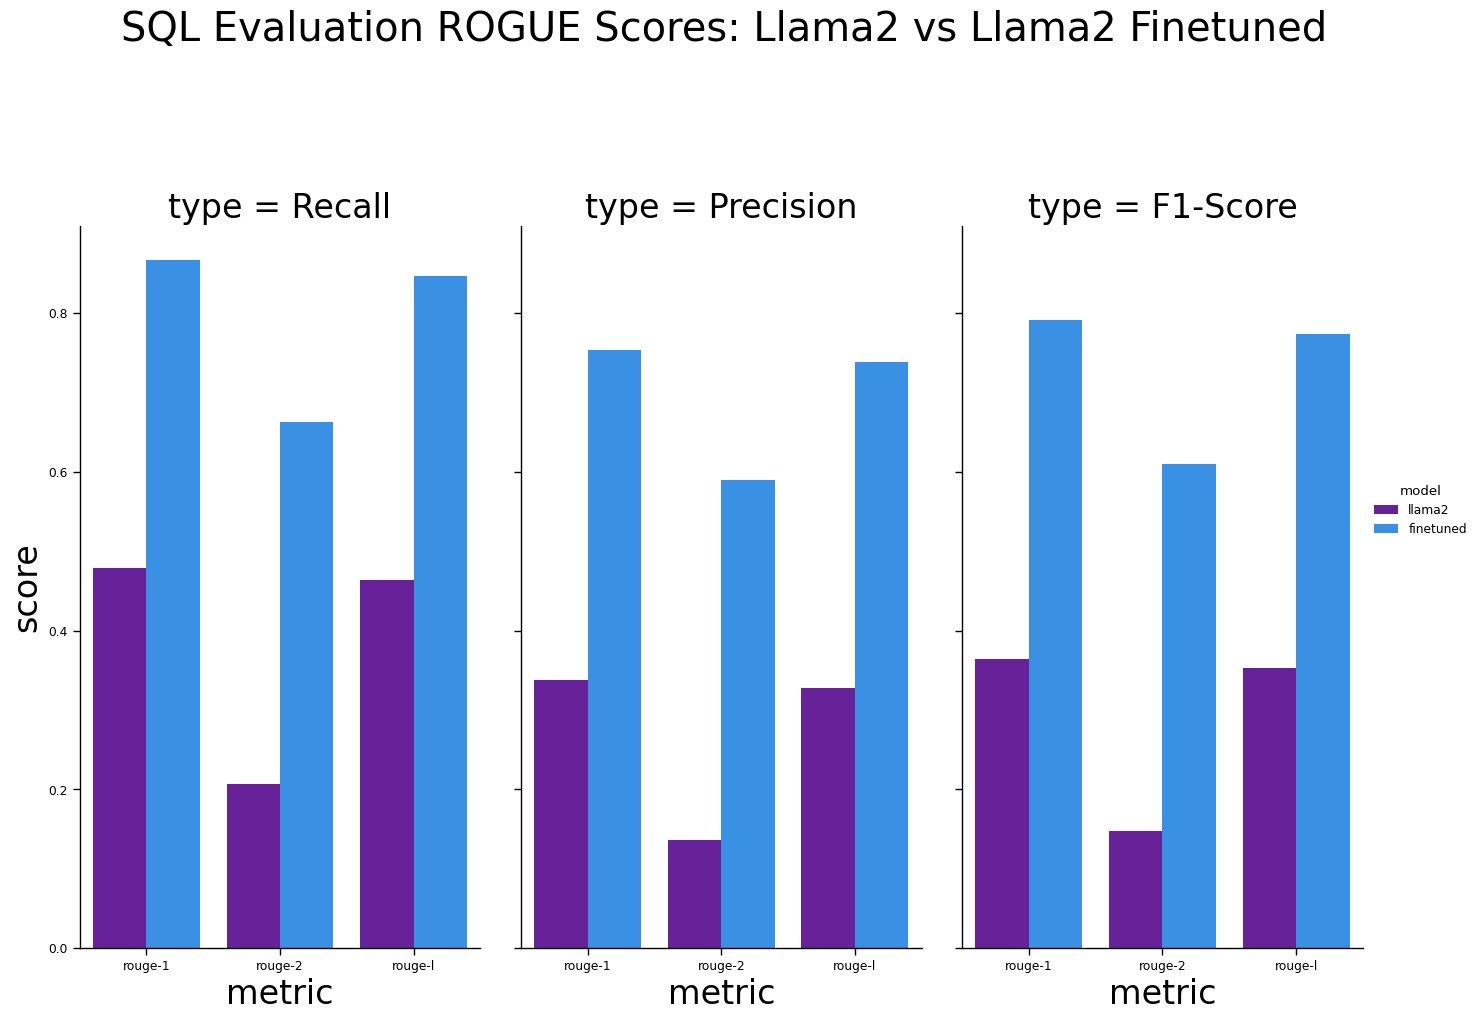

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define your custom color palette
custom_palette = ["#6A0DAD", "#1E90FF"]  # Purple & Dodger Blue
sns.set_context("paper", rc={"font.size":24, "axes.titlesize":30, "axes.labelsize":24})
cat = sns.catplot(x='metric', y='score', hue='model', col='type', kind='bar',
                  data=l2_ft_rogue_plt, palette=custom_palette)
cat.fig.subplots_adjust(top=.8)
cat.fig.suptitle('SQL Evaluation ROGUE Scores: Llama2 vs Llama2 Finetuned')
cat.fig.set_size_inches(15, 12)

plt.savefig(FIG_PATH + FIG_NAME)  # Save before showing
plt.show()
